Importing libraries and data

In [1]:
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Flatten, Input, GlobalAveragePooling2D
from keras.applications import DenseNet121
from keras.utils import to_categorical
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Loading the CIFAR-10 dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

In [3]:
#Reducing the number of images for faster training
x_train = x_train_full[:5000]
y_train = y_train_full[:5000]

x_test = x_test_full[:1000]
y_test = y_test_full[:1000]

In [4]:
#defining constants
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3) # Original CIFAR-10 size
TARGET_SHAPE = (224, 224) # Size required by DenseNet121 (for pre-trained weights)

In [5]:
print(f"Original training data shape: {x_train.shape}")

Original training data shape: (5000, 32, 32, 3)


Preprocessing and Resizing

In [6]:
# Function to resize the images to 224x224
def preprocess_image(image):
  # Resize the image to the target size (224x224)
  image = tf.image.resize(image, TARGET_SHAPE)
  # Convert to float and scale to [0, 1]
  image = tf.cast(image, tf.float32) / 255.0
  return image

In [7]:
#Applying one-hot encoding to labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

In [8]:
# Apply preprocessing to training and test data
x_train_resized = np.array([preprocess_image(img) for img in x_train])
x_test_resized = np.array([preprocess_image(img) for img in x_test])

In [9]:
print(f"Resized training data shape: {x_train_resized.shape}")

Resized training data shape: (5000, 224, 224, 3)


Build the DenseNet121 Transfer Learning Model

In [10]:
# include_top=False: Excludes the model's final classification layer
# weights='imagenet': Uses weights pre-trained on the ImageNet dataset
densenet_base = DenseNet121(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

# Freeze the Base Model Layers (Transfer Learning)
# This prevents the pre-trained weights from being changed during the initial training
densenet_base.trainable = False

# Create the New Classification Head
input_tensor = densenet_base.input
x = densenet_base.output

# Use GlobalAveragePooling2D instead of Flatten to maintain spatial relationships
x = GlobalAveragePooling2D()(x)

# Add a new classification layer
output_tensor = Dense(NUM_CLASSES, activation='softmax')(x)

# Final Model Creation
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the Model
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Train and Evaluate the Model

In [12]:
#train the model
history = model.fit(
    x_train_resized,
    y_train_cat,
    batch_size = 32,
    epochs = 1,
    validation_data = (x_test_resized, y_test_cat)
)

# Evaluate the Model
loss, accuracy = model.evaluate(x_test_resized, y_test_cat, verbose = 0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.5450 - loss: 1.3987 - val_accuracy: 0.6880 - val_loss: 0.9831

Test Loss: 0.9831
Test Accuracy: 68.80%


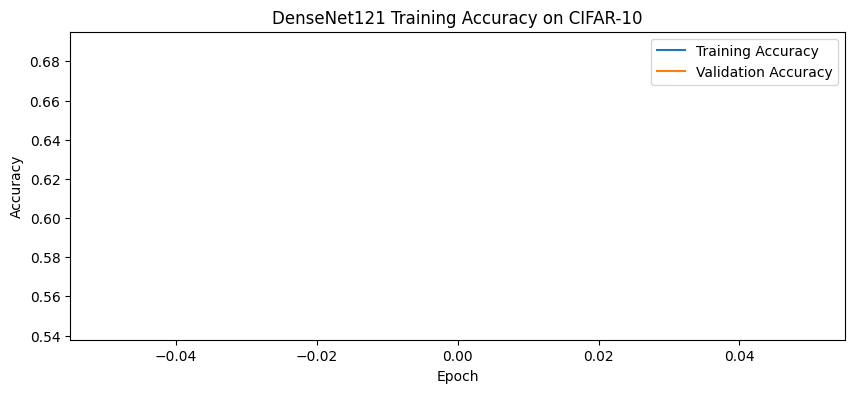

In [13]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet121 Training Accuracy on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()